In [3]:
import pandas
import numpy
import matplotlib
import os
import seaborn as sns
import numpy as np
import sklearn
import torch
import torch.nn as nn
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
df_raw = pandas.read_csv('./data/italy/covid19_italy_region.csv',
                        usecols=["Date", "RegionName", "Latitude", "Longitude", 
                        "NewPositiveCases", "TotalPositiveCases", "Deaths",
                        "TotalHospitalizedPatients", "IntensiveCarePatients"],
                        parse_dates=["Date"])
df_raw['Date'] = df_raw['Date'].dt.date
df_raw.set_index(["Date"], inplace=True)
df_raw.head()

,RegionName,Latitude,Longitude,IntensiveCarePatients,TotalHospitalizedPatients,NewPositiveCases,Deaths,TotalPositiveCases
Date,,,,,,,,
2020-02-24,Abruzzo,42.351222,13.398438,0,0,0,0,0
2020-02-24,Basilicata,40.639471,15.805148,0,0,0,0,0
2020-02-24,Calabria,38.905976,16.594402,0,0,0,0,0
2020-02-24,Campania,40.839566,14.250850,0,0,0,0,0
2020-02-24,Emilia-Romagna,44.494367,11.341721,2,12,18,0,18


In [5]:
df_pop =  pandas.read_csv('./data/italy/region_population.csv', index_col=['Territory'])

In [6]:
lat_df = df_raw[["RegionName", "Latitude", "Longitude"]]
lat_df = lat_df.drop_duplicates().sort_values(['Latitude'], ascending=False)
regions = lat_df['RegionName'].to_numpy()
lat_df

,RegionName,Latitude,Longitude
Date,,,
2020-02-24,P.A. Bolzano,46.499335,11.356624
2020-02-24,P.A. Trento,46.068935,11.121231
2020-02-24,Valle d'Aosta,45.737503,7.320149
2020-02-24,Friuli Venezia Giulia,45.649435,13.768136
2020-02-24,Lombardia,45.466794,9.190347
2020-02-24,Veneto,45.434905,12.338452
2020-02-24,Piemonte,45.073274,7.680687
2020-02-24,Emilia-Romagna,44.494367,11.341721
2020-02-24,Liguria,44.411493,8.932699


In [7]:
df_for_regions = {}
for region in regions:
    regional_df = df_raw.loc[df_raw.RegionName == region].copy()
    regional_df.drop(['RegionName', 'Latitude', 'Longitude'], axis=1, inplace=True)
    regional_df = regional_df.sort_values('Date')
    regional_df[['NewPositiveCaseDensity', 'DeathDensity', 'TotalPositiveCaseDensity']] = regional_df[["NewPositiveCases", "Deaths", "TotalPositiveCases"]] * 10000/df_pop.Value[region]
    regional_df[regional_df < 0] = 0
    regional_df = regional_df.iloc[0:150]
    regional_df = (regional_df-regional_df.min())/(regional_df.max()-regional_df.min())
    df_for_regions[region] = regional_df
df_for_regions['Abruzzo'].shape

(150, 8)

In [8]:
df_for_regions['Abruzzo'].head()

,IntensiveCarePatients,TotalHospitalizedPatients,NewPositiveCases,Deaths,TotalPositiveCases,NewPositiveCaseDensity,DeathDensity,TotalPositiveCaseDensity
Date,,,,,,,,
2020-02-24,0.0,0.000000,0.00000,0.0,0.000000,0.00000,0.0,0.000000
2020-02-25,0.0,0.000000,0.00000,0.0,0.000000,0.00000,0.0,0.000000
2020-02-26,0.0,0.000000,0.00000,0.0,0.000000,0.00000,0.0,0.000000
2020-02-27,0.0,0.002288,0.00625,0.0,0.000299,0.00625,0.0,0.000299
2020-02-28,0.0,0.002288,0.00000,0.0,0.000299,0.00000,0.0,0.000299


In [9]:
from matplotlib import pyplot as plt
sns.set(rc={'figure.figsize':(11.7,8.27)})

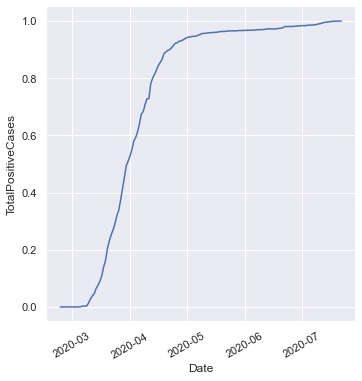

In [10]:
### plotting for P.A. Bolzano
plot = sns.relplot(data= df_for_regions['P.A. Bolzano'], x='Date', y='TotalPositiveCases', kind='line')
plot.set_xticklabels(rotation=30)

In [11]:
train_regions = np.array(['P.A. Bolzano', 'Emilia-Romagna', 'Liguria', 'Lombardia', 'Piemonte', 'P.A. Trento', "Valle d'Aosta", 'Veneto','Friuli Venezia Giulia'])
cv_regions = np.array(['Marche'])
test_regions = np.array(['Lazio', 'Sicilia', 'Campania'])
selected_regions = np.concatenate((train_regions, cv_regions, test_regions))
selected_regions

array(['P.A. Bolzano', 'Emilia-Romagna', 'Liguria', 'Lombardia',
       'Piemonte', 'P.A. Trento', "Valle d'Aosta", 'Veneto',
       'Friuli Venezia Giulia', 'Marche', 'Lazio', 'Sicilia', 'Campania'],
      dtype='<U21')

In [12]:
###create correlation df
corr_df = pandas.DataFrame()
for region in selected_regions:
    corr_df[region] = df_for_regions[region].NewPositiveCases
corr_df.head()

,P.A. Bolzano,Emilia-Romagna,Liguria,Lombardia,Piemonte,P.A. Trento,Valle d'Aosta,Veneto,Friuli Venezia Giulia,Marche,Lazio,Sicilia,Campania
Date,,,,,,,,,,,,,
2020-02-24,0.000000,0.010288,0.000000,0.045778,0.003012,0.0,0.0,0.054608,0.0,0.000000,0.009524,0.000000,0.000000
2020-02-25,0.007092,0.000000,0.003817,0.015466,0.000000,0.0,0.0,0.017065,0.0,0.000000,0.000000,0.017647,0.000000
2020-02-26,0.000000,0.013374,0.038168,0.000000,0.000000,0.0,0.0,0.047782,0.0,0.003731,0.000000,0.000000,0.000000
2020-02-27,0.000000,0.043210,0.030534,0.039282,0.000000,0.0,0.0,0.068259,0.0,0.007463,0.000000,0.005882,0.013333
2020-02-28,0.000000,0.041152,0.000000,0.034024,0.009036,0.0,0.0,0.068259,0.0,0.011194,0.000000,0.000000,0.004444


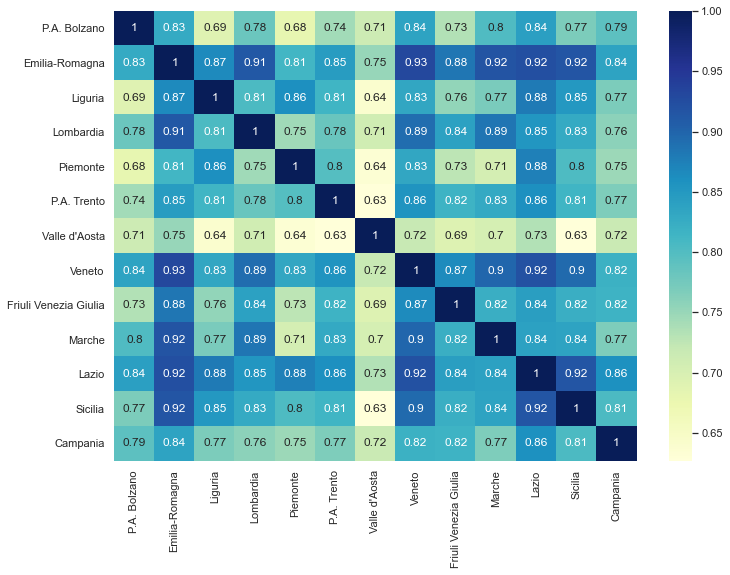

In [13]:
corrMatrix = corr_df.corr()
sns.heatmap(corrMatrix, annot=True, cmap="YlGnBu")
plt.show()

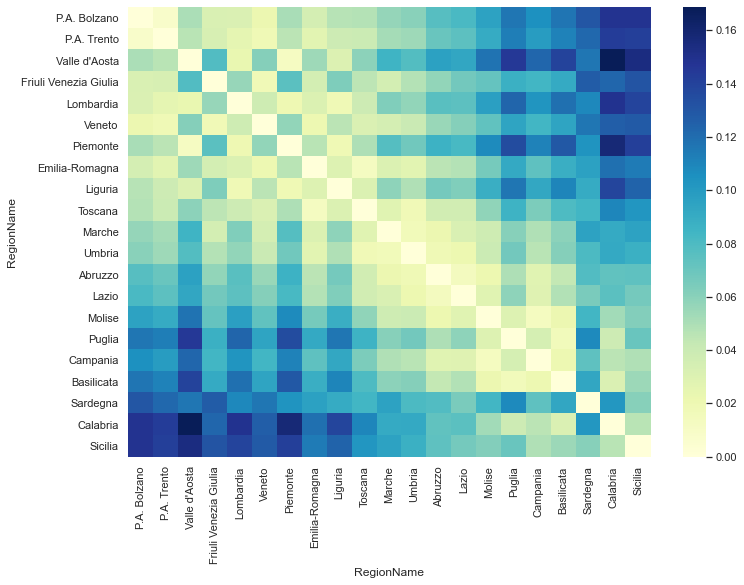

In [14]:
from sklearn.neighbors import DistanceMetric
lat_df['Latitude'] = np.radians(lat_df['Latitude'])
lat_df['Longitude'] = np.radians(lat_df['Longitude'])
dist = DistanceMetric.get_metric('haversine')
dist_matrix = dist.pairwise(lat_df[['Latitude', 'Longitude']]) #[lat_df['RegionName'].isin(selected_regions)]
dist_df = pandas.DataFrame(dist_matrix, columns=lat_df['RegionName'])
dist_df.set_index(lat_df['RegionName'], inplace=True)
sns.heatmap(dist_df, cmap="YlGnBu")
plt.show()

In [15]:
dist_df

RegionName,P.A. Bolzano,P.A. Trento,Valle d'Aosta,Friuli Venezia Giulia,Lombardia,Veneto,Piemonte,Emilia-Romagna,Liguria,Toscana,...,Umbria,Abruzzo,Lazio,Molise,Puglia,Campania,Basilicata,Sardegna,Calabria,Sicilia
RegionName,,,,,,,,,,,,,,,,,,,,,
P.A. Bolzano,0.000000,0.008031,0.050605,0.032748,0.031857,0.022068,0.051189,0.034994,0.046990,0.047665,...,0.060573,0.076734,0.081625,0.095665,0.116612,0.105303,0.116677,0.130322,0.148500,0.148581
P.A. Trento,0.008031,0.000000,0.046522,0.032994,0.025749,0.018498,0.045481,0.027614,0.039496,0.040172,...,0.054043,0.070857,0.074866,0.090446,0.112715,0.099490,0.111815,0.122360,0.143412,0.141796
Valle d'Aosta,0.050605,0.046522,0.000000,0.078602,0.023320,0.061513,0.012406,0.054066,0.030505,0.059652,...,0.078072,0.096430,0.093404,0.117867,0.145177,0.122633,0.139776,0.116135,0.168720,0.154331
Friuli Venezia Giulia,0.032748,0.032994,0.078602,0.000000,0.056026,0.017873,0.075307,0.036065,0.063424,0.045249,...,0.047598,0.057751,0.067532,0.072294,0.088183,0.084172,0.091198,0.127264,0.123202,0.131594
Lombardia,0.031857,0.025749,0.023320,0.056026,0.000000,0.038546,0.019774,0.031518,0.018691,0.039193,...,0.057375,0.075851,0.074945,0.097148,0.123400,0.103269,0.119149,0.109114,0.149130,0.139263
Veneto,0.022068,0.018498,0.061513,0.017873,0.038546,0.000000,0.057566,0.020517,0.045716,0.032032,...,0.040639,0.055446,0.061849,0.073764,0.094666,0.083813,0.094638,0.116242,0.126506,0.128434
Piemonte,0.051189,0.045481,0.012406,0.075307,0.019774,0.057566,0.000000,0.046460,0.019347,0.050035,...,0.068252,0.086339,0.082319,0.107723,0.135721,0.111751,0.129482,0.103897,0.157800,0.142200
Emilia-Romagna,0.034994,0.027614,0.054066,0.036065,0.031518,0.020517,0.046460,0.000000,0.030047,0.012702,...,0.027573,0.045591,0.047673,0.066460,0.091954,0.073898,0.088393,0.096583,0.119099,0.114427
Liguria,0.046990,0.039496,0.030505,0.063424,0.018691,0.045716,0.019347,0.030047,0.000000,0.031204,...,0.049147,0.067082,0.063050,0.088433,0.116647,0.092434,0.110155,0.090720,0.138499,0.124255


In [16]:
closest_regions = {}
for region in regions:
    closest_regions[region] = dist_df.loc[region].sort_values().iloc[1:10].index.values

In [17]:
def create_sequences(values, window_size=7):
    output = []
    for i in range(len(values) - window_size + 1):
        output.append(values[i : (i + window_size)])
    return np.stack(output)

In [18]:
temporal_dataset = {}
for region in regions:
    x = create_sequences(df_for_regions[region].to_numpy())
    temporal_dataset[region] = x

In [19]:
spatio_temporal_dataset = {}
for region in regions:
    result = []
    result.append(temporal_dataset[region])
    neighbours = closest_regions[region]
    for neighbour in neighbours:
        result.append(temporal_dataset[neighbour])
    spatio_temporal_dataset[region] = np.stack(result, axis=3)
    

In [20]:
spatio_temporal_dataset['Abruzzo'].shape

(144, 7, 8, 10)

In [21]:
train_regions

array(['P.A. Bolzano', 'Emilia-Romagna', 'Liguria', 'Lombardia',
       'Piemonte', 'P.A. Trento', "Valle d'Aosta", 'Veneto',
       'Friuli Venezia Giulia'], dtype='<U21')

In [102]:
train_dataset = np.transpose(np.vstack([spatio_temporal_dataset[region] for region in train_regions]), (0,2,1,3))
train_labels = np.vstack([temporal_dataset[region] for region in train_regions])

cv_dataset = np.transpose(np.vstack([spatio_temporal_dataset[region] for region in cv_regions]), (0,2,1,3))
cv_labels = np.vstack([temporal_dataset[region] for region in cv_regions])

test_dataset = np.transpose(np.vstack([spatio_temporal_dataset[region] for region in test_regions]), (0,2,1,3))
test_labels = np.vstack([temporal_dataset[region] for region in test_regions])

In [103]:
print(train_dataset.shape, train_labels.shape)

(1296, 8, 7, 10) (1296, 7, 8)


In [104]:
from torch.utils.data import TensorDataset, DataLoader
batch_size = 16 # mini-batch size
num_workers = 4 # how many parallel workers are we gonna use for reading data
shuffle = False

x_train = torch.FloatTensor(train_dataset)
y_train = torch.FloatTensor(train_labels)
tensor_train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(tensor_train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)

x_cv = torch.FloatTensor(cv_dataset)
y_cv = torch.FloatTensor(cv_labels)
tensor_cv_dataset = TensorDataset(x_cv, y_cv)
cv_loader = DataLoader(tensor_cv_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)

x_test = torch.FloatTensor(test_dataset)
y_test = torch.FloatTensor(test_labels)
tensor_test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(tensor_test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)



In [105]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [100]:
input = torch.randn(16, 16, 7, 4)
m = nn.Conv2d(16, 16, 2, stride=(1,3), padding=(1,0), dilation=(2,1))
m(input).shape

torch.Size([16, 16, 7, 1])

In [128]:
torch.manual_seed(0)
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity = 'relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain = nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

In [113]:
class Encoder(nn.Module):
    
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=2, stride=(1,3), padding=(1,2), dilation=(2,1)), #op 16*7*7
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=16, out_channels=4, kernel_size=2, stride=(1,3), padding=(1,0), dilation=(2,2)), #op 4*7*1
            nn.BatchNorm2d(4),
            nn.LeakyReLU(),
        )

        

    def forward(self, x):
        z = self.encoder(x)
        return z

In [124]:
class Decoder(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, output_size, num_layers, batch_first=True)

        

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        out, (hn, cn) = self.lstm1(x, (h0,c0))
        out, _ = self.lstm2(out, (hn, cn))
        return out

In [126]:
class AutoEncoder(nn.Module):
    
    def __init__(self, latent_size=4, output_size=8, num_lstm_layers=2):
        super(AutoEncoder, self).__init__()
        
        self.encoder = Encoder()
        self.decoder = Decoder(latent_size, output_size, output_size, num_lstm_layers)

        

    def forward(self, x):
        encoding = self.encoder(x)
        encoding = torch.transpose(encoding[:,:,:,0], 1, 2)
        y_pred = self.decoder(encoding)
        return y_pred

In [129]:
def Solver(model, train_loader, optim, criterion, epoch=10, lr=1e-1, print_every=10):
  '''
  The solver function for training your model

  model: your designed model
  train_loader: data loader for training data
  optim: your optimizer
  criterion: criterion for calculating loss, i.e. nn.CrosssEntropyLoss
  epoch: number of training epochs, an epoch means looping through all the data in the datasets
  lr: training learning rate
  print_every: number of epochs to print out loss and accuracies
  '''

  # Send model to GPU for training.
  model.to(device)

  for e in range(epoch):
      loss_epoch = 0
      for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        
        optim.zero_grad()
        y_pred = model(x)
        #if torch.any(y_pred.isnan()): break
        loss =  criterion(y_pred, y)
        #print(loss)
        loss.backward()
        optim.step()
        loss_epoch += loss.item()
      if print_every <= epoch and e % print_every == 0:  
          print(f'Epoch {e}: {loss_epoch}')
  return model

In [132]:
def create_model():
    epoch = 100
    lr = 1e-4
    latent_size = 4
    output_size = x_train.shape[1] #8
    num_lstm_layers = 2
    batch_size = 16
    model = AutoEncoder(latent_size, output_size, num_lstm_layers)
    model.apply(initialize_parameters)
    optim = torch.optim.Adam(model.parameters())
    criterion = nn.L1Loss()
    model = Solver(model, train_loader, optim, criterion, epoch=epoch, lr=lr, print_every=1)
    torch.save(model, 'ae2-model.pth')
    print('Model created and saved successfully')

In [133]:
create_model()

Epoch 0: 32.882805570960045
Epoch 1: 24.216181948781013
Epoch 2: 19.618343137204647
Epoch 3: 15.741303004324436
Epoch 4: 12.406479004770517
Epoch 5: 10.907674983143806
Epoch 6: 9.877746172249317
Epoch 7: 8.957887476310134
Epoch 8: 8.132636652328074
Epoch 9: 7.601799418218434
Epoch 10: 7.216894540004432
Epoch 11: 6.772638431750238
Epoch 12: 6.420027306303382
Epoch 13: 6.161956340074539
Epoch 14: 5.898990603163838
Epoch 15: 5.7418698482215405
Epoch 16: 5.55865318980068
Epoch 17: 5.46646685525775
Epoch 18: 5.359518034383655
Epoch 19: 5.270634857006371
Epoch 20: 5.224654044024646
Epoch 21: 5.155852550640702
Epoch 22: 5.080971479881555
Epoch 23: 5.065369389951229
Epoch 24: 5.057332300581038
Epoch 25: 5.082936916965991
Epoch 26: 5.061740690842271
Epoch 27: 5.126950388774276
Epoch 28: 5.384510434232652
Epoch 29: 5.251291798427701
Epoch 30: 5.209752828814089
Epoch 31: 5.197109870612621
Epoch 32: 5.17949132528156
Epoch 33: 5.125452879816294
Epoch 34: 5.153409651480615
Epoch 35: 5.12219676841050

In [134]:
model = torch.load('ae2-model.pth')

In [135]:
def predict(x):
    x = x.to(device)
    y_pred = model(x)
    return y_pred

In [136]:
print(x_train.shape)
x_train_pred = predict(x_train).detach().numpy()
x_train_pred.shape

torch.Size([1296, 8, 7, 10])


(1296, 7, 8)

In [137]:
train_labels = y_train.detach().numpy()
reconstructed_cases = x_train_pred[:,0, 4]
actual_cases = train_labels[:,0, 4]
cases_train_mae_loss = np.abs(reconstructed_cases - actual_cases)


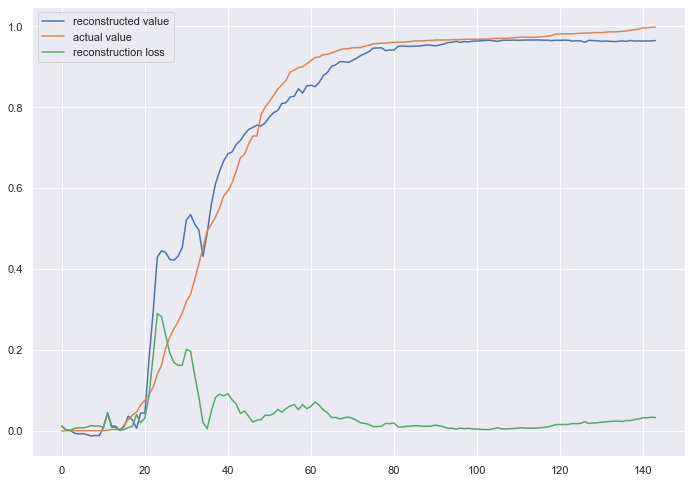

In [138]:
plt.plot(reconstructed_cases[0:144], label="reconstructed value")
plt.plot(actual_cases[0:144], label="actual value")
plt.plot(cases_train_mae_loss[0:144], label="reconstruction loss")
plt.legend(loc="upper left")
plt.show()

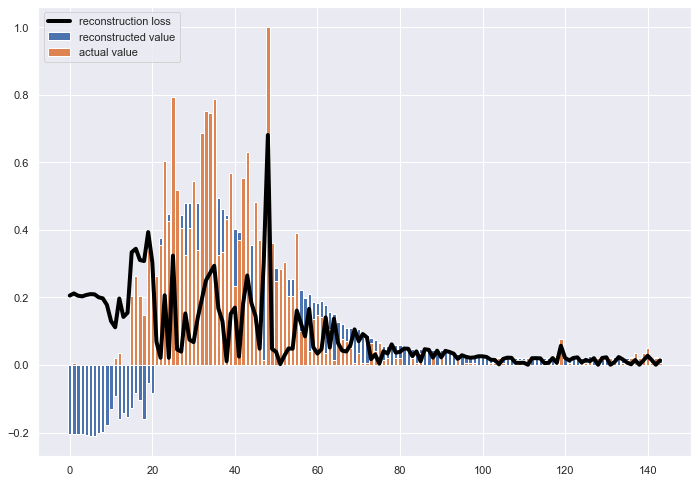

In [139]:
reconstructed_daily_cases = x_train_pred[:,0, 2]
actual_daily_cases = train_labels[:,0, 2]
daily_cases_train_mae_loss = np.abs(reconstructed_daily_cases - actual_daily_cases)
plt.bar(range(0,144),reconstructed_daily_cases[0:144], label="reconstructed value")
plt.bar(range(0,144),actual_daily_cases[0:144], label="actual value")
plt.plot(daily_cases_train_mae_loss[0:144], color='black', linewidth=4, label="reconstruction loss")
plt.legend(loc="upper left")
plt.show()

In [140]:
a = daily_cases_train_mae_loss[0:144]
np.argwhere(a>0.1)

array([[ 0],
       [ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19],
       [20],
       [23],
       [25],
       [28],
       [31],
       [32],
       [33],
       [34],
       [35],
       [36],
       [37],
       [39],
       [40],
       [42],
       [43],
       [44],
       [45],
       [47],
       [48],
       [55],
       [56],
       [58],
       [62],
       [64],
       [69]], dtype=int64)

In [141]:
print(x_test[0:144].shape)
x_test_pred = predict(x_test[0:144]).detach().numpy()
x_test_pred.shape

torch.Size([144, 8, 7, 10])


(144, 7, 8)

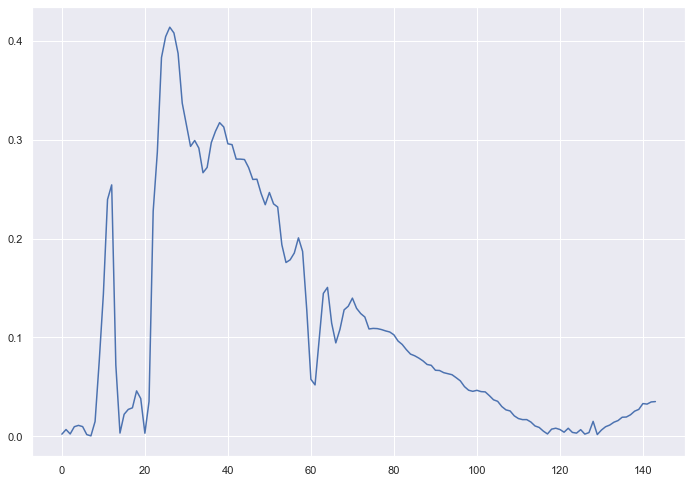

In [142]:
test_labels = y_test[0:144].detach().numpy()
reconstructed_cases = x_test_pred[:,0, 4]
actual_cases = test_labels[:,0, 4]
test_mae_loss = np.abs(reconstructed_cases - actual_cases)
plt.plot(test_mae_loss)

In [144]:
print(x_test[144:288].shape)
x_test_pred = predict(x_test[144:288]).detach().numpy()
x_test_pred.shape

torch.Size([144, 8, 7, 10])


(144, 7, 8)

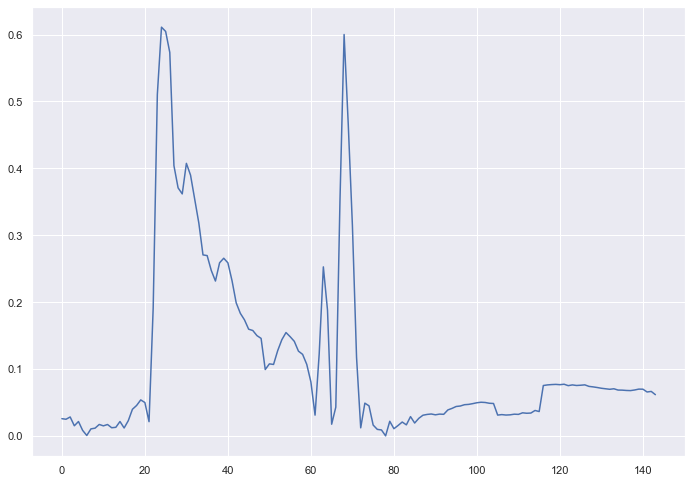

In [145]:
test_labels = y_test[144:288].detach().numpy()
reconstructed_cases = x_test_pred[:,0, 4]
actual_cases = test_labels[:,0, 4]
test_mae_loss = np.abs(reconstructed_cases - actual_cases)
plt.plot(test_mae_loss)

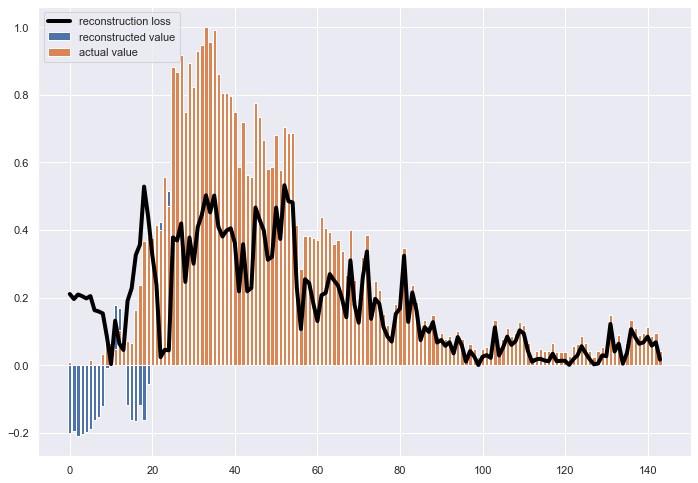

In [143]:
reconstructed_daily_cases = x_test_pred[:,0, 2]
actual_daily_cases = test_labels[:,0, 2][0:144]
daily_cases_test_mae_loss = np.abs(reconstructed_daily_cases - actual_daily_cases)
plt.bar(range(0,144),reconstructed_daily_cases[0:144], label="reconstructed value")
plt.bar(range(0,144),actual_daily_cases[0:144], label="actual value")
plt.plot(daily_cases_test_mae_loss[0:144], color='black', linewidth=4, label="reconstruction loss")
plt.legend(loc="upper left")
plt.show()

In [41]:
x_train_pred.shape

(1296, 7, 8)

In [42]:
def reconstruct_data(subseq_data):
    output = []
    for time_stamp in subseq_data:
        if np.all(time_stamp == subseq_data[-1]) :
            for seq in time_stamp:
                output.append(seq)
        else:
            obs = time_stamp[1,:]
            output.append(obs)
    return np.stack(output)
            



In [43]:
len(x_train_pred)
rec = reconstruct_data(x_train_pred[0:144])
reconstructed_train_df = pandas.DataFrame(rec, columns=df_for_regions['Abruzzo'].columns, index = df_for_regions['Abruzzo'].index)
reconstructed_train_df

,IntensiveCarePatients,TotalHospitalizedPatients,NewPositiveCases,Deaths,TotalPositiveCases,NewPositiveCaseDensity,DeathDensity,TotalPositiveCaseDensity
Date,,,,,,,,
2020-02-24,-0.021185,0.002518,-0.000863,0.027726,-0.006293,-0.034461,0.032240,0.041961
2020-02-25,-0.021425,0.002760,-0.001057,0.026652,-0.006783,-0.034424,0.031673,0.040751
2020-02-26,-0.022260,0.002902,-0.001436,0.024725,-0.007613,-0.034783,0.031057,0.039772
2020-02-27,-0.022744,0.002606,-0.001777,0.022859,-0.007891,-0.035128,0.029949,0.038113
2020-02-28,-0.022991,0.002698,-0.002027,0.021484,-0.007885,-0.034925,0.028809,0.036247
...,...,...,...,...,...,...,...,...
2020-07-18,0.006334,0.019508,0.006923,0.992230,0.987125,0.008763,0.992934,0.987441
2020-07-19,0.006141,0.018722,0.006629,0.992550,0.987673,0.008268,0.993194,0.987777
2020-07-20,0.006086,0.018551,0.006524,0.992706,0.987928,0.008018,0.993298,0.987887


In [44]:
df_for_regions['P.A. Bolzano']

,IntensiveCarePatients,TotalHospitalizedPatients,NewPositiveCases,Deaths,TotalPositiveCases,NewPositiveCaseDensity,DeathDensity,TotalPositiveCaseDensity
Date,,,,,,,,
2020-02-24,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
2020-02-25,0.0,0.002571,0.007092,0.0,0.000372,0.007092,0.0,0.000372
2020-02-26,0.0,0.002571,0.000000,0.0,0.000372,0.000000,0.0,0.000372
2020-02-27,0.0,0.002571,0.000000,0.0,0.000372,0.000000,0.0,0.000372
2020-02-28,0.0,0.002571,0.000000,0.0,0.000372,0.000000,0.0,0.000372
...,...,...,...,...,...,...,...,...
2020-07-18,0.0,0.015424,0.007092,1.0,0.999255,0.007092,1.0,0.999255
2020-07-19,0.0,0.015424,0.007092,1.0,0.999628,0.007092,1.0,0.999628
2020-07-20,0.0,0.015424,0.000000,1.0,0.999628,0.000000,1.0,0.999628
